# Análisis de performance de agentes
## Búsqueda Local

In [112]:
import NQueens
import random
import multiprocessing as mp
import pandas as pd
import seaborn as sns
from copy import copy
from time import time_ns

## Se llevará a cabo con la siguiente configuración:

In [113]:
algorithms = [NQueens.hill_climbing]
sizes = [4, 8, 10, 12, 15]
limit_factor = 100
iterations = 30
h_behavior_size = 100
random.seed(42)

---

# Tiempo de ejecución

## Correr simulación

In [135]:
def run_simulation(simulations, algorithms, size, limit):
    # Create common board
    base_board = random.sample(range(size), size)
    
    # Run in each agent
    for algorithm in algorithms:
        start = time_ns()
        
        # Run agent
        best_h, steps, _ = algorithm(copy(base_board), limit)
        end = time_ns()
        
        # Append results in the siumlations dict
        simulations.append({
            'algorithm': algorithm.__name__,
            'size': size,
            'best_h': best_h,
            'steps': steps,
            'time_ms': (end-start)/1e6
        })

In [136]:
# Using parallelism :D
with mp.Manager() as manager:
    simulations = manager.list() #List thread-safe. (overkill, find alternatives)
    pool = mp.Pool() #use all available cores, otherwise specify the number you want as an argument
    
    # Test iterations
    for size in sizes:
        for _ in range(iterations):
            pool.apply_async(run_simulation, args=(simulations, algorithms, size, size**limit_factor))

    # Wait for all threads to finish
    pool.close()
    pool.join()
    
    # Save it as a pandas dataframe
    simulations_df = pd.DataFrame(list(simulations))

simulations_df.to_csv('simulations.csv')
simulations_df

,algorithm,size,best_h,steps,time_ms
0,hill_climbing,4,1,12,0.281114
1,hill_climbing,4,1,48,0.922425
2,hill_climbing,4,1,48,0.764671
3,hill_climbing,4,0,48,0.877997
4,hill_climbing,4,0,36,0.706329
...,...,...,...,...,...
145,hill_climbing,15,3,2100,43.014823
146,hill_climbing,15,3,420,8.545600
147,hill_climbing,15,2,1680,35.146731
148,hill_climbing,15,2,1680,32.852731


## Análisis del performance de cada algorítmo

In [137]:
samples_list = []

for algorithm in algorithms:
    for size in sizes:
        sample_df = simulations_df.query(f'algorithm == "{algorithm.__name__}" and size == {size}')
        
        # Find optimals
        try:
            optimals = sample_df.best_h.value_counts().loc[0]
        except KeyError:
            optimals = 0
        
        # Save saple report
        samples_list.append({
            'algorithm': algorithm.__name__,
            'size': size,
            'optimal_rate': optimals / iterations,
            'time_ms_avg': sample_df['time_ms'].mean(),
            'time_ms_std': sample_df['time_ms'].std(),
            'steps_avg': sample_df['steps'].mean(),
            'steps_std': sample_df['steps'].std()
        })

# Print table
samples_df = pd.DataFrame(samples_list)
samples_df.to_csv('samples.csv')
samples_df

,algorithm,size,optimal_rate,time_ms_avg,time_ms_std,steps_avg,steps_std
0,hill_climbing,4,0.200000,0.438454,0.311199,24.000000,18.643664
1,hill_climbing,8,0.166667,4.053659,1.827176,233.333333,100.910795
2,hill_climbing,10,0.033333,8.298302,3.319792,480.000000,191.040707
3,hill_climbing,12,0.066667,15.076686,5.422973,827.200000,298.064376
4,hill_climbing,15,0.033333,30.523933,11.926864,1547.000000,607.846113


## Gráficos
### Box plot - Tiempo empleado hasta llegar a una solución

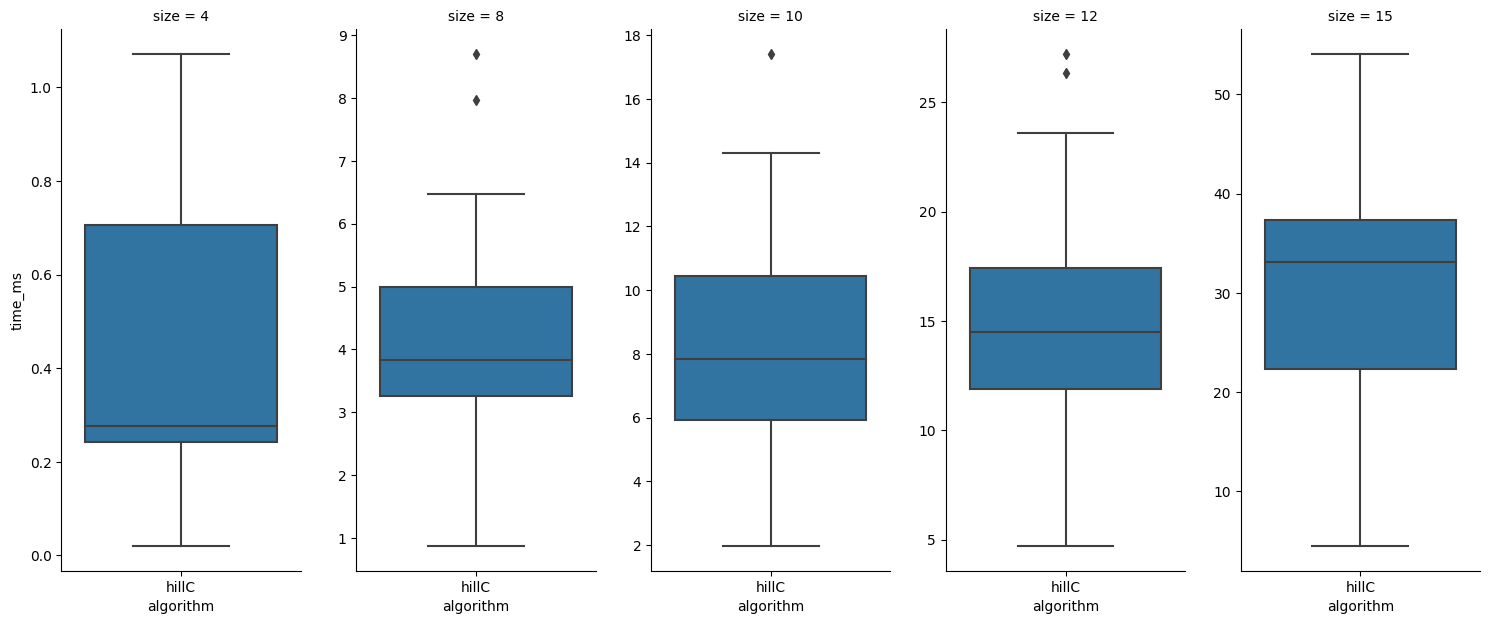

In [138]:
%matplotlib inline

grid1 = sns.FacetGrid(data=simulations_df, col='size', sharey=False)
grid1.map(sns.boxplot, 'algorithm', 'time_ms', order= [x.__name__ for x in algorithms])
grid1.set_xticklabels(['hillC'])

grid1.fig.subplots_adjust(top=2)
grid1.savefig('time_by_algorithm.svg')


# Comportamiento de h()

In [139]:
def run_simulation_h_history(simulations, algorithms, size, limit):
    # Create common board
    base_board = random.sample(range(size), size)
    
    # Run in each agent
    for algorithm in algorithms:
        # Run agent
        _, _, h_history = algorithm(copy(base_board), limit)
        
        # Append results in the siumlations dict
        simulations.append({
            'algorithm': algorithm.__name__,
            'h_history': h_history
        })

In [140]:
with mp.Manager() as manager:
    simulations_h = manager.list() #List thread-safe. (overkill, find alternatives)
    pool = mp.Pool() #use all available cores, otherwise specify the number you want as an argument
    
    # Run
    pool.apply_async(run_simulation_h_history, args=(simulations_h, algorithms, 
                                                     h_behavior_size, h_behavior_size**limit_factor))

    # Wait for all threads to finish
    pool.close()
    pool.join()
    
    # Save it as a pandas dataframe
    simulations_h_df = pd.DataFrame(list(simulations_h))

simulations_h_df.to_csv('simulations_h.csv')
simulations_h_df

,algorithm,h_history
0,hill_climbing,"[75, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 6..."


### Box plot - Comportamiento de h()dd

In [144]:
%matplotlib inline

simulations_h_df['h_'].plot.line()

TypeError: no numeric data to plot